# Massively parallel phage display panning against _P. aeruginosa_ cells (`fig-panning-massive`)

Note: portions of this figure are generated in the notebooks for `panning-extended`: [barplots](../../../panning-extended/workflow/notebooks/fig-panning-massive-extended.ipynb)

In [1]:
import nbseq
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotnine
from plotnine import *

In [3]:
import nbseq.viz.sample
from nbseq.viz.utils import extract_encoded_data_plotnine

In [4]:
# setup matplotlib to render figures as SVG with editable text preserved at appropriate font size
FONT_SIZE = 5

plt.rcParams.update({
    "font.family":"sans",
    "font.size": FONT_SIZE,
    "svg.fonttype": "none"
})

In [5]:
%config InlineBackend.figure_formats = ['svg']

***

In [6]:
ex = nbseq.Experiment.from_files(ft_aa=None,
                                 tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')

Loading experiment panning-massive from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (3.8 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (29.0 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at 'intermediate/cdr3/features_db/features' does not exist!
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.70 seconds


In [7]:
ex.obs['OprOP'] = np.nan

In [8]:
ex

Experiment('panning-massive') with feature spaces ['cdr3']:
  obs: ['plate' 'well' 'depth' 'expt' 'round' 'sample' 'phage_library' 'notes'
    'r' 'io' 'kind' 'selection' 'replicate' 'name_full' 'name' 'well_027e'
    'sel_plate' 'sel_well' 'category' 'antigen' 'genotype_pair' 'gene_CS'
    'gene_S' 'genotype_CS' 'background_CS' 'strain_CS' 'loc_CS' 'cond_CS'
    'genotype_S' 'background_S' 'strain_S' 'loc_S' 'cond_S' 'cond_notes'  'bflm'
    'swim' 'twitch' 'swarm' 'PMB-R' 'FEP-R' 'TET-R' 'CIP-R' 'CHL-R'  'GEN-R'
    'ERY-R' 'IPM-R' 'cdiGMP' 'FliC' 'FliCa' 'FliCb' 'FlgEHKL' 'PilQ'  'PilA'
    'PilB' 'LasA' 'LasB' 'Apr' 'XcpQ' 'ToxA' 'EstA' 'LepA' 'PlpD'  'Phz' 'Pcn'
    'Pvd' 'Hcn' 'Rhl' 'T3SS' 'T6SS' 'Pel' 'Psl' 'CdrB' 'SCV'  'Mucoid'
    'Alginate' 'OprM' 'OprJ' 'OprN' 'OprP' 'OpdH' 'OprD' 'OprL'  'OprF' 'OprG'
    'OprH' 'OprB' 'MexAB' 'MexCD' 'MexEF' 'MexJK' 'MexXY'  'MexGHI' 'PirA' 'Pfu'
    'TonB' 'FptA' 'FpvA' 'PfeA' 'CupB5' 'CupA' 'CupB'  'CupC' 'CupD' 'LPS-
    LipidA-Palmito

In [9]:
# shorten some descriptions for presentation
from nbseq.viz.utils import shorten_descriptions
import re
replacements = {
    re.compile(r"(\w+)\#[^\s:]+"): r"\1",
    "ZTP riboswitch":"...",
    "PAO397":"PAO1",
}

shorten_descriptions(ex.obs, replacements=replacements);
shorten_descriptions(ex.fts.cdr3.obs, replacements=replacements);
ex.fts.cdr3.obs['desc_short_ml'] = ex.fts.cdr3.obs['desc_short'].str.replace("/","\n").str.replace("PAO397","")

## Barplots and Whittaker Plots

In [10]:
def top_asv_barplot(ex, query, space='cdr3', n=30, select_from_round=4, phylo=False, **kwargs):
    samples = ex.query_ids(f"({query}) & kind =='+' & io == 'i'", space=space)
    if select_from_round is not None:
        top_from_samples = ex.query_ids(f"({query}) & r == {select_from_round} & kind =='+' & io == 'i'", space=space)
    else:
        top_from_samples = None
    
    
    ft_top = nbseq.viz.sample.collapse_top_asvs(ex.fts[space], samples, top_from_samples = top_from_samples, n=n)
    df = nbseq.ft.fortify(ft_top, obs=True, relative=True)
    
    if phylo:
        return nbseq.viz.sample.top_asv_plot_phylo(df, ex.tree[space], **kwargs)
    else: 
        return nbseq.viz.sample.top_asv_barplot(df, feature_name=space.upper(), **kwargs)

def cleanup_source_data(df):
    df['desc_short_ml'] = df['desc_short_ml'].str.replace('\n',' vs. ')
    df.rename(columns={'desc_short_ml':'selection condition'}, inplace=True)
    return df

### FlgEHKL (`fig-panning-massive`d--e), OprM (`fig-suppl-hts-massive-efflux`)

In [11]:
layers = [
    theme_bw(), 
    theme(
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
    )
]

def make_barplot(query, name):
    gg = (
    top_asv_barplot(ex, 
                     query, 
                     facet={'facets':"selection+'\\n'+desc_short_ml", 'ncol':4}, n=40) 
    )
    gg += layers
    gg += theme(figure_size=(4,2))
    gg.save(f"results/plots/barplots/{name}.svg")
    df = cleanup_source_data(extract_encoded_data_plotnine(gg)).to_csv(f"results/tables/figures/barplots/{name}.csv", index=False)
    return gg

In [12]:
%%bash
mkdir -p results/plots/{barplots,rank_abundance}
mkdir -p results/tables/figures/{barplots,rank_abundance}

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/flhA_vs_fleN_fliC.svg


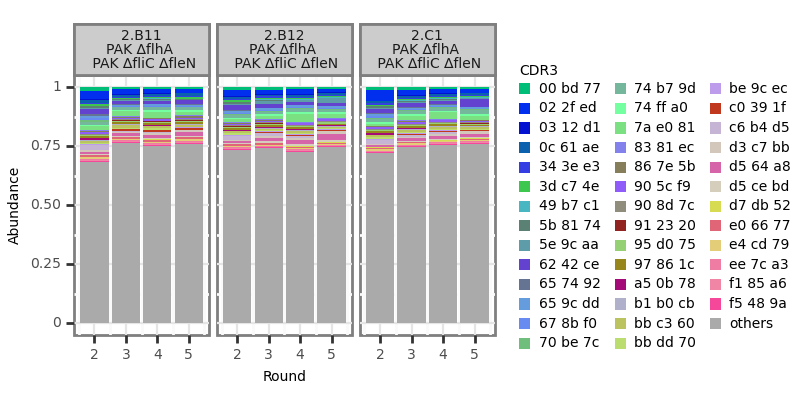

<Figure Size: (400 x 200)>

In [13]:
make_barplot(f"genotype_pair == 'flhA/fleN fliC'","flhA_vs_fleN_fliC")

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4 x 2 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/barplots/efflux_vs_oprM.svg


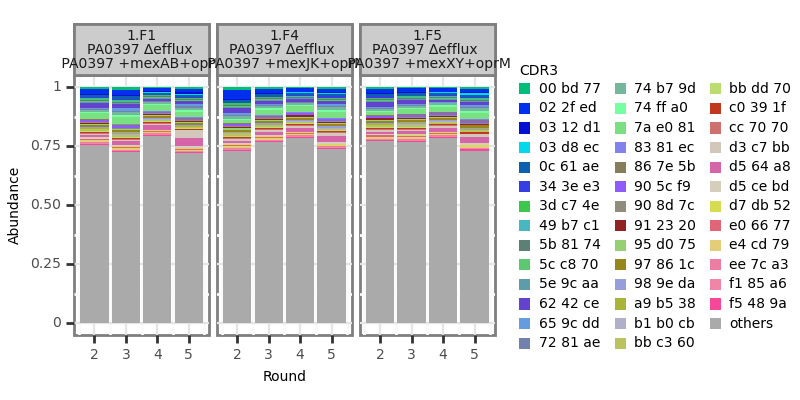

<Figure Size: (400 x 200)>

In [14]:
make_barplot(f"genotype_S == '+mexAB+oprM' | genotype_S == '+mexJK+oprM' | genotype_S == '+mexXY+oprM'", "efflux_vs_oprM")

In [15]:
# import nbseq.viz.sample as nvs
# import nbseq.viz.tree
# import nbseq.ft as nbft
# from nbseq.utils import replace_multiple

In [16]:
def whittaker(ex, library, space='cdr3', predicates='', **kwargs):
    query = f"phage_library == '{library}' & replicate == 1 & io == 'i' & kind == '+'"
    if predicates != '':
        query += f" & ({predicates})"
    ft = ex.query(query, space=space)

    return nbseq.viz.sample.rank_abundance_plot(ft, **kwargs)

from matplotlib.ticker import EngFormatter

fmt = EngFormatter(sep="")
def order_facets(column, order):
    def _reorder(df):
        df[column] = df[column].astype("category").cat.reorder_categories(order)
        return df
    return _reorder

layers_whittaker = [
    scale_color_cmap("viridis"),
    scale_x_continuous(name="feature rank", labels=lambda x: list(map(fmt.format_eng, x))),
    facet_wrap("selection+'\\n'+desc_short_ml", nrow=1),
    theme_bw(), 
    theme(
        legend_key_height=4,
        legend_key_width=4,
        text=element_text(family='sans', size=5)
    ),
    guides(color=guide_legend(title="round"))
]

def make_whittaker(query, name):
    g = whittaker(ex, 'alpaca', 
              predicates=query,
              color="r", 
              n_sample=dict(n=20, replace=True),
              line=dict(size=1),
              group="r",
              # transform=order_facets("desc_ag_short", ["PAK flagellum", "PAO1 flagellum", "PAK pilus", "PA103 pilus"])
             )
    g += layers_whittaker
    g += theme(figure_size=(3,1.5))
    g.save(f"results/plots/rank_abundance/{name}.svg")
    cleanup_source_data(extract_encoded_data_plotnine(g)).to_csv(f"results/tables/figures/rank_abundance/{name}.csv", index=False)
    return g

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 1.5 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/flhA_vs_fleN_fliC.svg


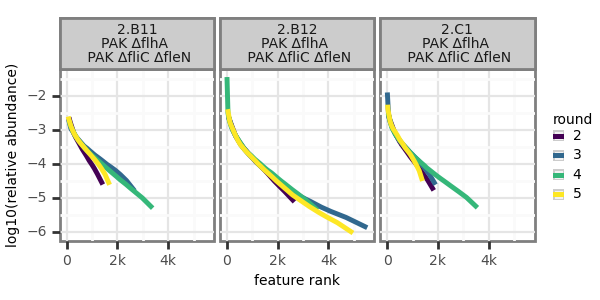

<Figure Size: (300 x 150)>

In [17]:
make_whittaker("genotype_pair == 'flhA/fleN fliC'", "flhA_vs_fleN_fliC")

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 3 x 1.5 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/rank_abundance/efflux_vs_oprM.svg


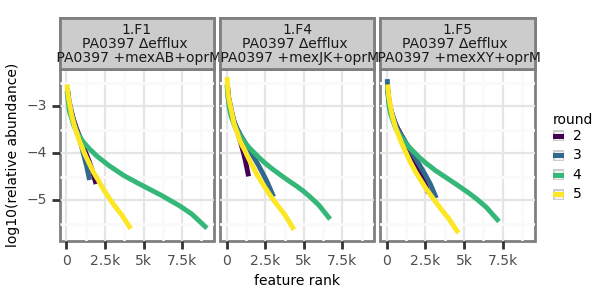

<Figure Size: (300 x 150)>

In [18]:
make_whittaker("genotype_S == '+mexAB+oprM' | genotype_S == '+mexJK+oprM' | genotype_S == '+mexXY+oprM'", "efflux_vs_oprM")

### Raw library

CDR3, top 100 features

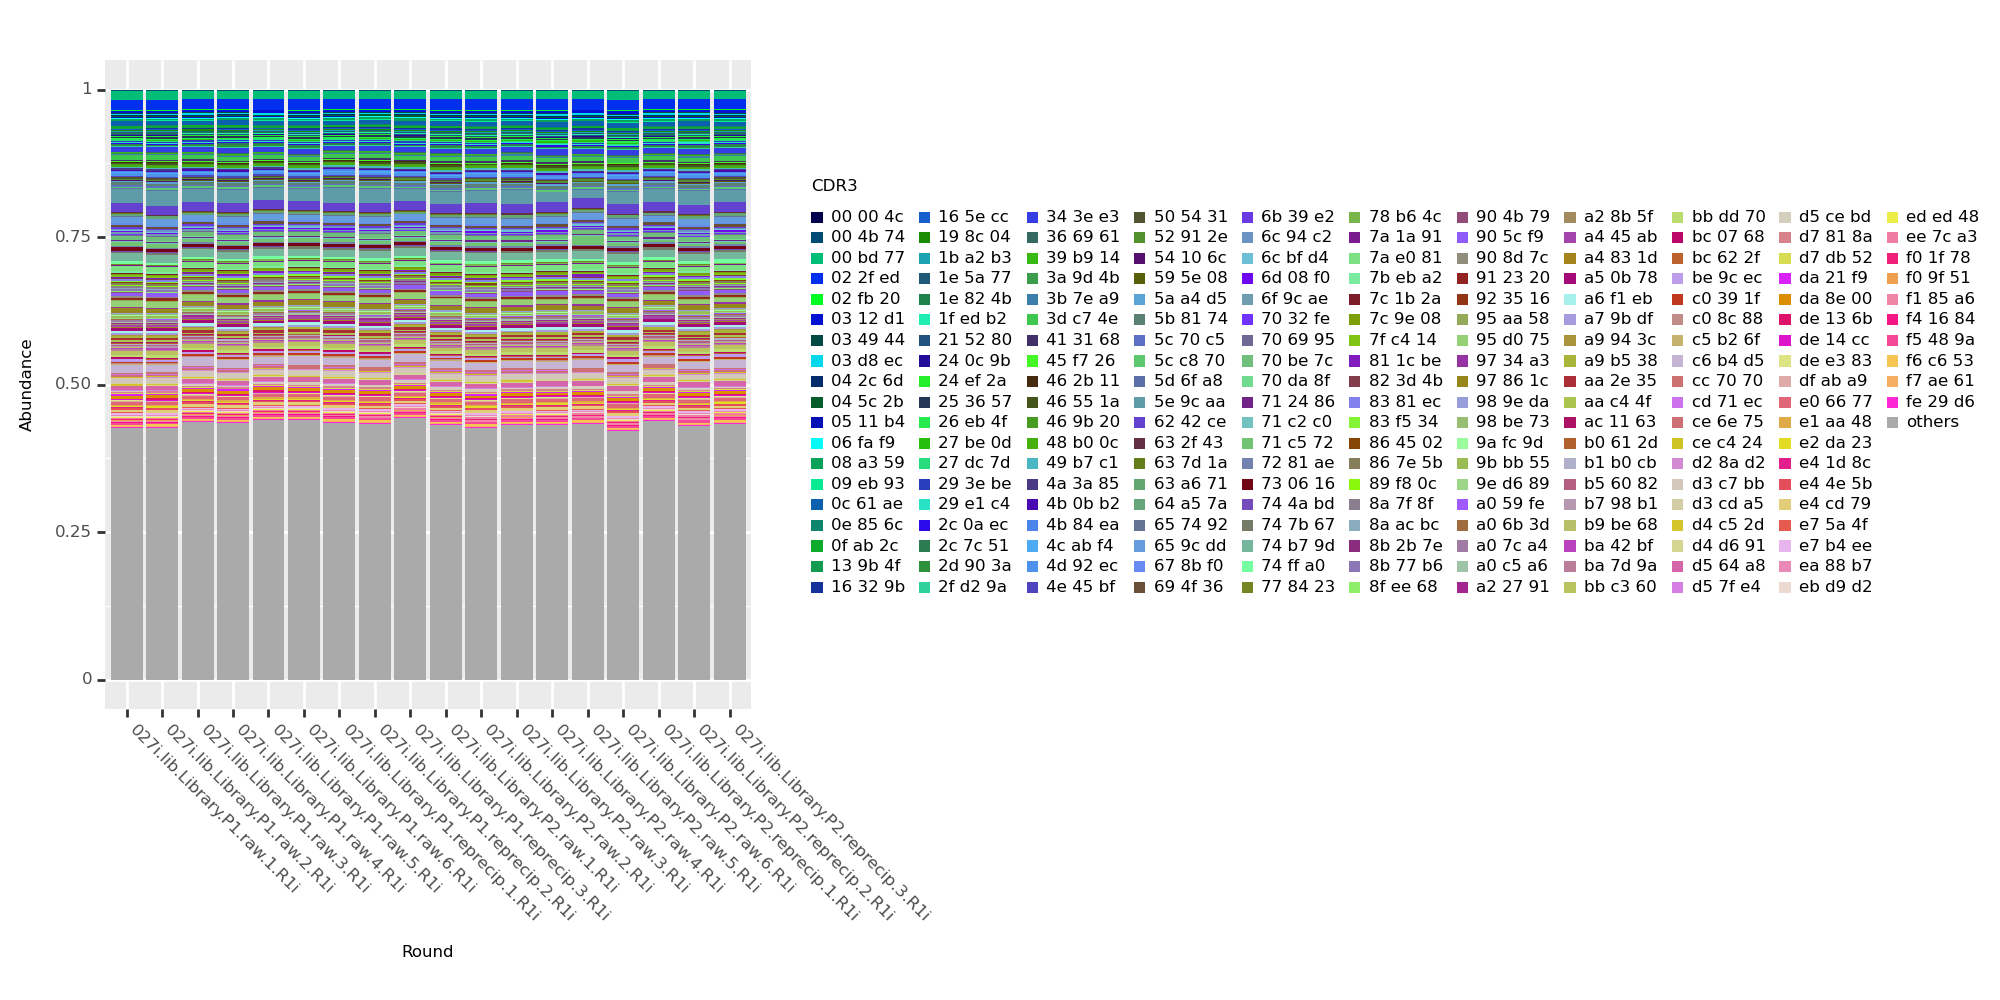

<Figure Size: (1000 x 500)>

In [19]:
(top_asv_barplot(ex, "expt == '027i.lib'", x='name_full', select_from_round=None, n=200) 
 + theme(
     figure_size=(10,5), 
     axis_text_x=element_text(rotation=-45, hjust=0),
     legend_key_height=4,
     legend_key_width=4,
     text=element_text(family='sans', size=6)
  )
)

### Replicate barplots

In [20]:
metadata_name = ex.obs.query("expt == '027i' & kind == '+' & io == 'i'").drop_duplicates(subset='name', keep='first').fillna('')

n_replicates = metadata_name.groupby("genotype_CS	background_CS	cond_CS	genotype_S	background_S	strain_S	cond_S	description".split("\t"))['sample'].count().rename('n_samples')

In [21]:
replicates = n_replicates[n_replicates > 2].to_frame()
replicates

n_samples
genotype_CS                   background_CS cond_CS genotype_S                    background_S strain_S cond_S description                                                  
                              SA113                 WT                            PA14         430             SA113 / PA14 WT                                             3
                                            scrape  WT                            PA14         430      scrape SA113 / PA14 WT                                             3
gacA::Tn(GmR) fliC::TcR ∆pilA PAO1                  retS::Tn(GmR) fliC::TcR ∆pilA PAO1         Tom#223         PAO1 gacA::Tn(GmR) fliC::TcR ∆pilA / PAO1 retS:...          3
∆flhA                         PAK                   ∆fliC ∆fleN                   PAK          1330            PAK ∆flhA / PAK ∆fliC ∆fleN                                 3
∆pilQ                         PAO1          scrape  ∆pilA                         PAO1         311      scrape PAO1 ∆pilQ / PAO1 ∆pilA                                     3

In [22]:
replicate_conds = replicates.reset_index().set_index('description')
replicate_conds

,genotype_CS,background_CS,cond_CS,genotype_S,background_S,strain_S,cond_S,n_samples
description,,,,,,,,
SA113 / PA14 WT,,SA113,,WT,PA14,430,,3
SA113 / PA14 WT,,SA113,scrape,WT,PA14,430,scrape,3
PAO1 gacA::Tn(GmR) fliC::TcR ∆pilA / PAO1 retS::Tn(GmR) fliC::TcR ∆pilA,gacA::Tn(GmR) fliC::TcR ∆pilA,PAO1,,retS::Tn(GmR) fliC::TcR ∆pilA,PAO1,Tom#223,,3
PAK ∆flhA / PAK ∆fliC ∆fleN,∆flhA,PAK,,∆fliC ∆fleN,PAK,1330,,3
PAO1 ∆pilQ / PAO1 ∆pilA,∆pilQ,PAO1,scrape,∆pilA,PAO1,311,scrape,3


In [23]:
# for description, cond in replicate_conds.iterrows():
#     query = "kind == '+' & io =='i' & " + " & ".join(f"({k} == '{cond[k]}')" for k in cond.index if ((k != 'n_samples') and cond[k]))
#     print(description)
#     print(query)
#     n_samples = cond['n_samples']
#     gg = top_asv_barplot(ex, query, facet={'facets':"selection+'\\n'+description", 'ncol':4}, n=100) + theme(figure_size=(12,max((n_samples//4),1)*8/3))
#     display(gg)

## Phenotype barplots

### CDR3

In [24]:
ex.fts.cdr3.obs.query("selection == '1.G11'").loc['01-G11','desc_short_ml']

'PA14 oprM::Tn \n PA14 mexL::Tn'

In [25]:
test_ags = ['FliC', 'FliCa', 'FliCb', 'FlgEHKL', 'PilQ', 'PilA', 'Pel', 'Psl', 'OprM', 'T3SS']

In [26]:
from IPython.display import Markdown

In [27]:
%%bash
mkdir -p results/plots/barplots_suppl/

In [28]:
# ncol = 6
# for antigen in ['FliC', 'FlgEHKL', 'PilQ', 'PilA', 'Pel', 'Psl', 'OprM', 'T3SS']:#list(ex.ag_names)[0:5]:
# # for antigen in test_ags:
#     display(Markdown(f"#### {antigen}"))
#     n_samples = ex.obs.query(f"`{antigen}` == 1")['selection'].nunique()

#     gg = top_asv_barplot(ex, f"`{antigen}` == 1", facet={'facets':"selection+'\\n'+desc_short_ml", 'ncol':ncol}, n=100) 
#     gg += theme_bw()
#     gg += theme(
#         figure_size=(10,max((n_samples//ncol),1)*4/3), 
#         legend_key_height=4,
#         legend_key_width=4,
#         text=element_text(family='sans', size=5)
#                )

#     gg.save(f"results/plots/barplots_suppl/{antigen}.svg")
#     display(gg)

## Enrichment histogram plot

In [29]:
from nbseq.ft import query as ft_query
import nbseq.select as nbselect
import matplotlib.ticker as ticker

In [30]:
# subset feature table to include only antigen-positive eluates, post-amplifcation samples, from appropriate experiment
global_query="kind == '+' & io == 'i' & expt == '027i'"
ft = ft_query(ex.rfts['cdr3'], global_query, axis='obs')

In [31]:
# calculate enrichment
enr_comparison = ('start', 'end')
df_enr = nbselect.enr(ft,'df',comparison=enr_comparison, add_start_end=True, add_log=True, dropna=True)
nbselect.enrichment_pvalues(df_enr, abundance_col=enr_comparison[0], inplace=True);
df_enr = df_enr.join(ex.selection_metadata[['desc_short','description']], on="name")

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10


In [32]:
# reorder selection according to the antigen category
df_categories = ex.selection_metadata.copy()
df_categories['category'] = (df_categories['category']
                               .fillna('library')
                               .replace({'alginate':'EPS', 'biofilm':'EPS', 'c-di-GMP':'EPS'}))

# use this order for antigen category
categories = [
    'library', 'general', 'clinical isolate', 
    'regulator','QS','iron',
    'efflux','porin', 'secretion',
    'motility', 'fimbrae',
    'LPS', 'EPS', 
]

df_categories = df_categories.sort_values('category', key=lambda x: x.apply(categories.index))
selections = nbseq.utils.intersection_ordered(df_categories.index, df_enr.name)

df_enr = df_enr.loc[df_enr.name.isin(selections),:]
df_categories = df_categories.loc[selections,:]

x_order = df_categories.index

In [33]:
# color points by first 6 digits of CDR3ID (MD5 hash of CDR3 sequence)
md5_palette = {x: '#'+x[0:6] for x in df_enr.CDR3ID}
df_enr['color'] = '#'+df_enr['CDR3ID'].str.slice(0,6)

# downsample to reduce overplotting
dff = df_enr.query('sig').sample(10000)

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
/tmp/ipykernel_2796856/2549903588.py:32: UserWarning: The figure layout has changed to tight


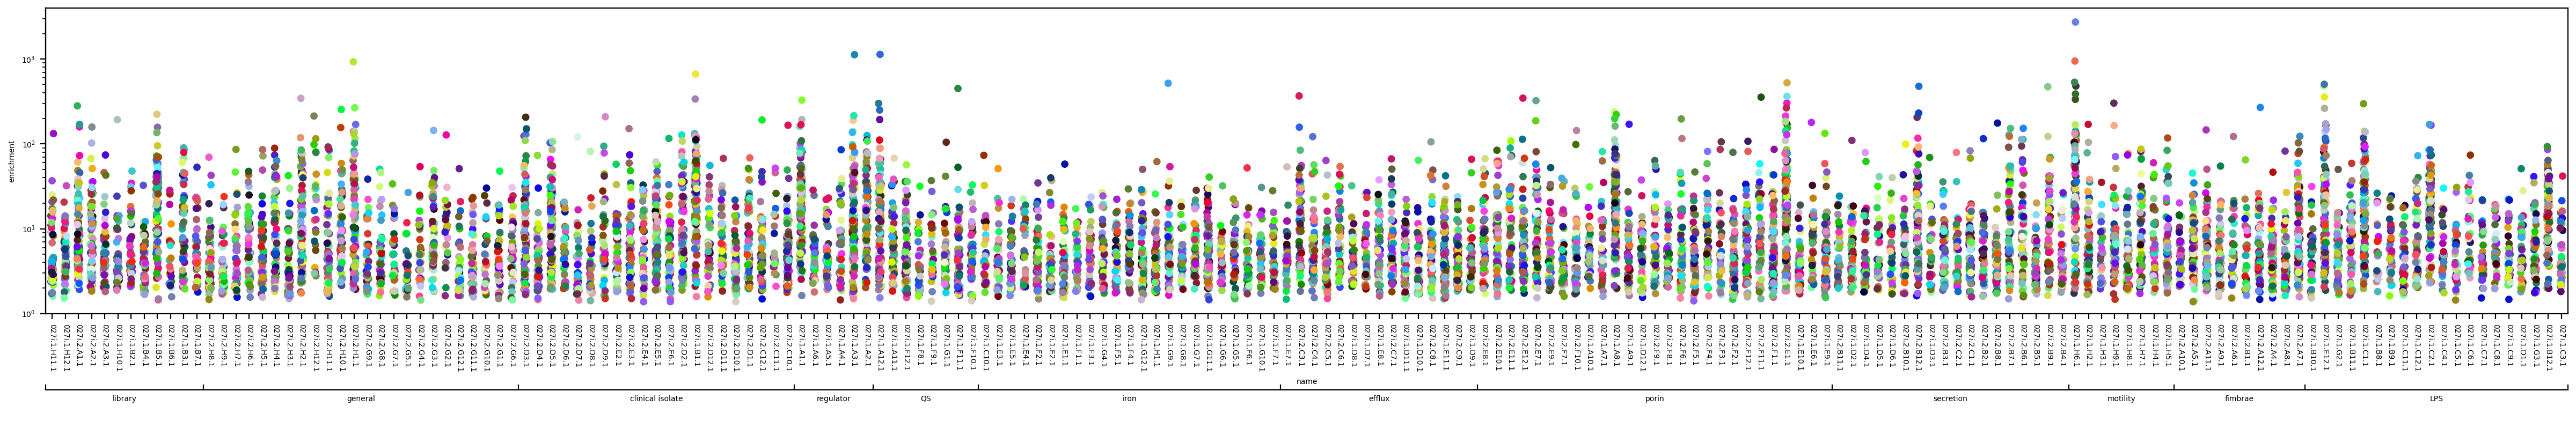

In [34]:
g = sns.catplot(data=dff, x='name', y='enrichment', hue='CDR3ID', kind='strip', order=x_order, height=4, aspect=6, legend=None, palette=md5_palette)
g.set(yscale="log", ylim=(1, None))
g.set_xticklabels(rotation=-90)

# Second X-axis
ax2 = g.ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# number of items in each category
cat_sizes = df_categories.groupby('category', sort=False).size()

# relative widths of categories (sums to 1)
cat_widths = cat_sizes / cat_sizes.sum()

# position of ticks separating categories
tick_pos = [0] + list(cat_widths.cumsum())

# position of labels in midpoint of each category (i.e. tick position plus half of category width)
label_pos = tick_pos[:-1] + cat_widths/2

ax2.set_xticks(tick_pos)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(label_pos))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(categories))

g.fig.tight_layout()
plt.show()

g.fig.savefig('results/plots/enrichment.svg')

In [35]:
# save source data file
(dff.join(df_categories['category'], on='name')
 [['category', 'name', 'desc_short', 'enrichment', 'CDR3ID', 'nlogp']]
 .rename(columns={'desc_short': 'description', 'nlogp':'-log10(enrichment probability)'})
 .to_csv('results/tables/figures/enrichment.csv')
)

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
/tmp/ipykernel_2796856/3338288723.py:34: UserWarning: The figure layout has changed to tight


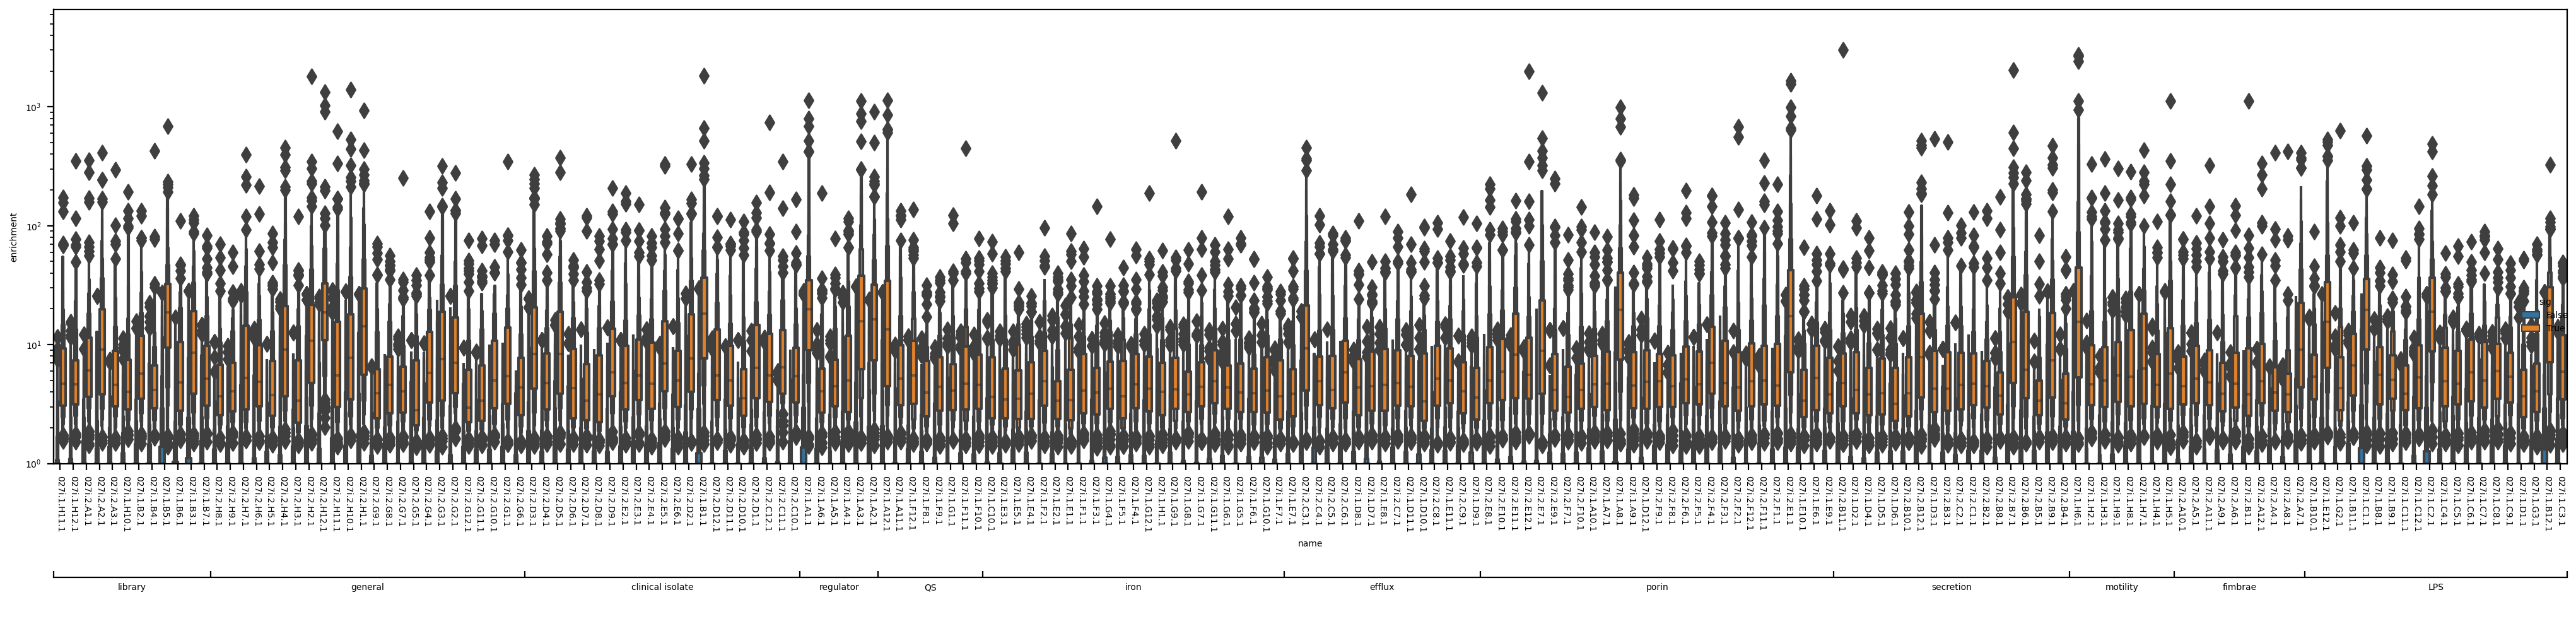

In [36]:
# g = sns.catplot(data=enrichment_df, x='description', y='enrichment', alpha=0.1, height=10, aspect=4)
g = sns.catplot(data=df_enr, x='name', y='enrichment', hue='sig', kind='boxen', order=x_order, height=5, aspect=4)
g.set(yscale="log", ylim=(1, None))
g.set_xticklabels(rotation=-90)
# plt.legend(title='significance', labels=['p < 0.01', 'ns'])

# Second X-axis
ax2 = g.ax.twiny()

ax2.spines["bottom"].set_position(("axes", -0.25))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")


# number of items in each category
cat_sizes = df_categories.groupby('category', sort=False).size()

# relative widths of categories (sums to 1)
cat_widths = cat_sizes / cat_sizes.sum()

# position of ticks separating categories
tick_pos = [0] + list(cat_widths.cumsum())

# position of labels in midpoint of each category (i.e. tick position plus half of category width)
label_pos = tick_pos[:-1] + cat_widths/2

ax2.set_xticks(tick_pos)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(label_pos))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(categories))

g.fig.tight_layout()
plt.show()

## Antigen matrix

In [37]:
%%bash
mkdir -p results/plots/antigens

In [38]:
phenotypes = ex._phenotypes.reset_index()
pheno_grid =  ex.selection_metadata.loc[x_order,phenotypes.loc[phenotypes.type == 'antigen', 'name']]

In [39]:
# meta = metadata.drop_duplicates('name').set_index('name')
# meta = meta.query("kind == '+'")

# descriptions = meta.reindex(ag_matrix.index)['description'].fillna('contrived negative').apply(trunc_ellipsis()).to_frame()
# descriptions['x'] = range(len(descriptions))

def plot_ag_matrix(
    mtxs, x_order=None, kws=None, labels=None, ax=None, figsize=(30,20), fig_kws={},
    ag_grouping_pos=-0.07,
    ag_grouping_tick_length=45,
    table_height = 0.45,
):
    
    if fig_kws is None:
        fig_kws = dict()
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, **fig_kws)
    
    if kws is None:
        kws = [{}] * len(mtxs)
    if labels is None:
        labels = [None]*len(mtxs)

    ax.grid(True)        
    ax.set_axisbelow(True)

    ag_matrix = mtxs[0]

    if x_order is None:
        x_order = ag_matrix.index

    strain_pair = ex.selection_metadata.loc[x_order,"desc_short"].str.split("/")
    descriptions = pd.DataFrame({
        "x": range(len(x_order)), 
        "description": ex.selection_metadata.loc[x_order,:].index + " : " + ex.selection_metadata.loc[x_order,"desc_short"],
        "cond": ex.selection_metadata.loc[x_order,'cond_S'],
        "CS": strain_pair.apply(lambda x: x[0]),
        "S" : strain_pair.apply(lambda x: x[1]),
    }, index=x_order)

    
    ag_metadata = ex.ags.loc[ag_matrix.columns,:].copy()
    ag_metadata.index.rename('name', inplace=True)
    ag_categories = ag_metadata.reset_index().sort_values(['category','name']).set_index('name', drop=True)
    ag_category_labels = ag_categories['category'].unique()
    
    antigens = ag_matrix.columns
    antigen_positions = { ag:i for i, ag in enumerate(antigens) }
    
    for ag_matrix, kwargs, label in zip(mtxs, kws, labels):
        ag_matrix = ag_matrix.loc[:,ag_categories.index]
        
        df = ag_matrix.reset_index().melt(id_vars='name', var_name='antigen')

        names = ag_matrix.index.values
        pos = df.query('value == 1')
        neg = df[(~df['value'].isna()) & (df['value'] != 1)]

        
        # ax.scatter(descriptions.loc[df['name'],'x'], df['antigen'], c=df['value'])
        ax.scatter(descriptions.loc[pos['name'],'x'], pos['antigen'].replace(antigen_positions), label=f'{label}+' if label is not None else '+', color='tab:orange', **kwargs)
        ax.scatter(descriptions.loc[neg['name'],'x'], neg['antigen'].replace(antigen_positions), label=f'{label}-' if label is not None else '-', color='tab:blue', **kwargs)

    # ax.set_xticks(descriptions.x, descriptions.description, rotation=-90);
    ax.set_xticks(descriptions.x, [], rotation=-90);
    ax.set_yticks(list(antigen_positions.values()), antigen_positions.keys());
    ax.legend()


    n_selections = descriptions.x.max()
    n_antigens = len(antigen_positions)

    # ax.margins(x=1/n_selections, y=0)
    ax.margins(0)
    ax.set_xlim(-0.5, n_selections+0.5)
    ax.set_ylim(-0.5, (n_antigens-1)+0.5)

    cellText = descriptions.sort_values("x")[["CS","S"]].T.values
    
    table = ax.table(cellText=cellText, 
                     # bbox=(0,-table_height,(n_selections+1)/n_selections, table_height)
                     bbox=(0,-table_height,1, table_height)
                    )

    # this is a dict of tuples to cells, not a 2D array
    cells = table.properties()["celld"]
    for i in range(cellText.shape[0]):
        for j in range(cellText.shape[1]):
            cells[i,j].set_text_props(rotation=-90, 
                                      fontsize=10
                                     )
            cells[i,j].set_height(table_height/2)


    ax.tick_params('x', length=0, width=0)
    
    # second Y-axis for antigen category labels
    ax2 = ax.twinx()

    ax2.spines["left"].set_position(("axes", ag_grouping_pos))
    ax2.tick_params('both', length=0, width=0, which='minor')
    ax2.tick_params('both', direction='in', length=ag_grouping_tick_length, which='major')
    ax2.yaxis.set_ticks_position("left")
    ax2.yaxis.set_label_position("left")
    
    
    # number of items in each category
    
    cat_sizes = ag_categories.groupby('category', sort=False).size()
    
    # relative widths of categories (sums to 1)
    cat_widths = cat_sizes / cat_sizes.sum()
    
    # position of ticks separating categories
    tick_pos = [0] + list(cat_widths.cumsum())
    
    # position of labels in midpoint of each category (i.e. tick position plus half of category width)
    label_pos = tick_pos[:-1] + cat_widths/2
    
    ax2.set_yticks(tick_pos)
    ax2.yaxis.set_major_formatter(ticker.NullFormatter())
    ax2.yaxis.set_minor_locator(ticker.FixedLocator(label_pos))
    ax2.yaxis.set_minor_formatter(ticker.FixedFormatter(ag_category_labels))
    
    return fig, ax

### Full Antigen Matrix `fig-suppl-antigen-matrix-full`

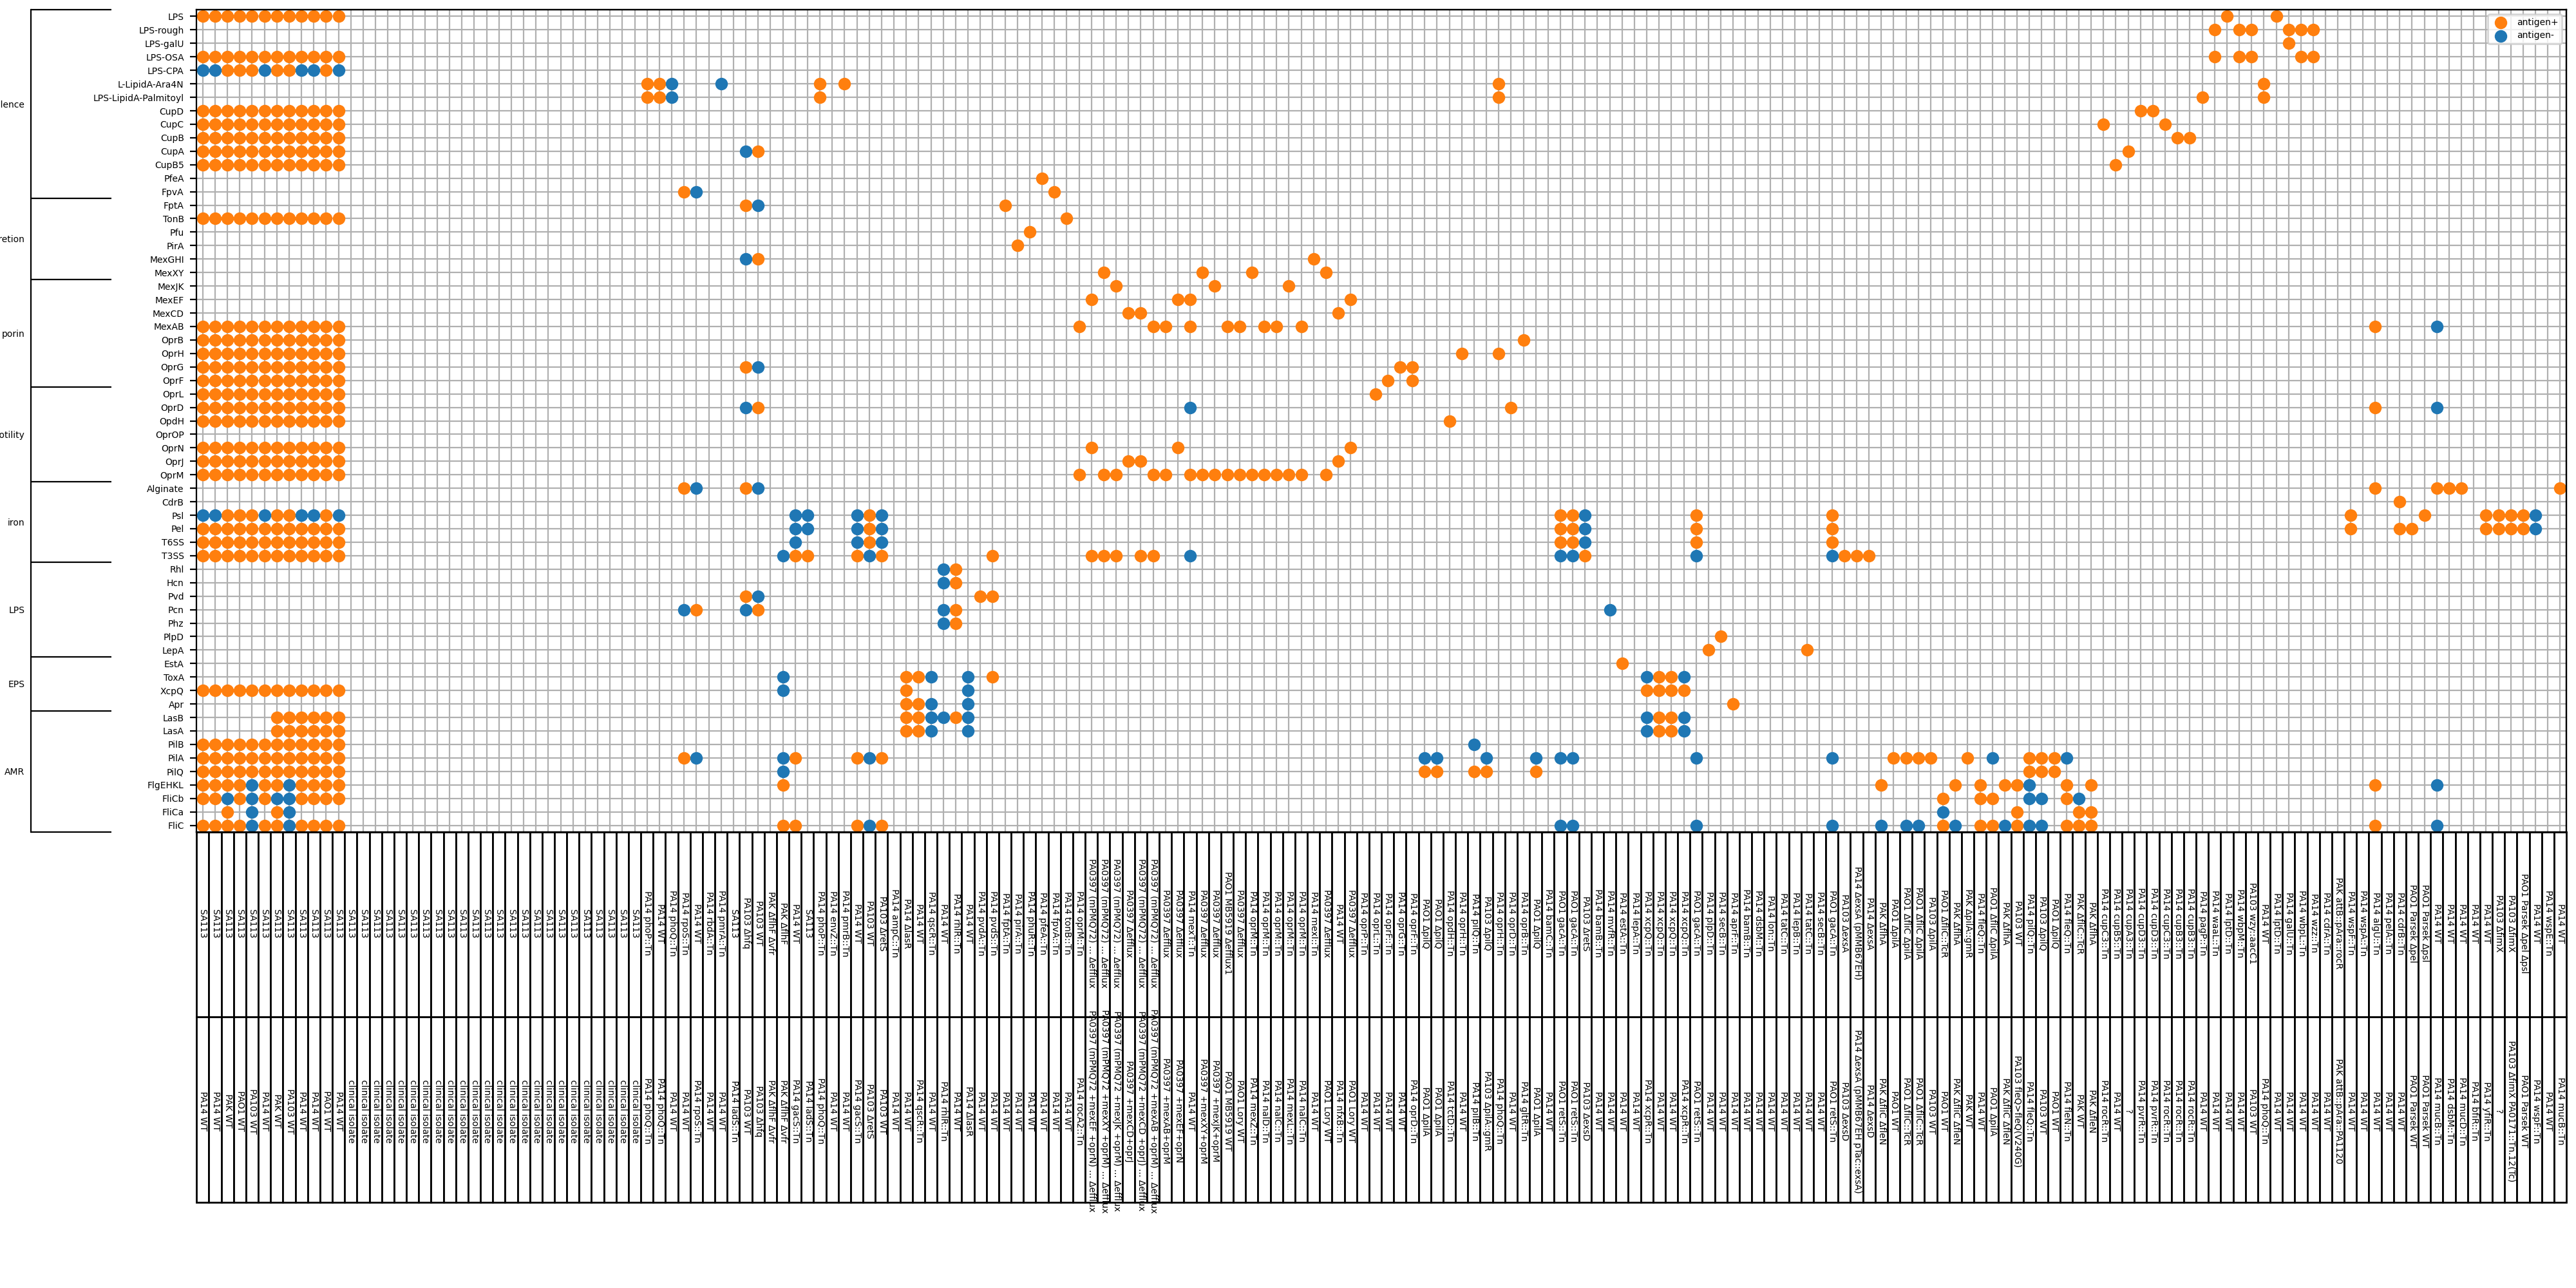

In [40]:
fig, ax = plot_ag_matrix([pheno_grid], x_order=x_order, kws=[{}], figsize=(20,10), labels=['antigen'])

fig.tight_layout()
plt.show()
fig.savefig("results/plots/antigens/matrix_full.svg")

### Subset antigen matrix (`fig-panning-massive`c)

In [41]:
strain_pair = ex.selection_metadata.loc[x_order,"desc_short"].str.split("/")
descriptions = pd.DataFrame({
    "x": range(len(x_order)), 
    "description": ex.selection_metadata.loc[x_order,:].index + " : " + ex.selection_metadata.loc[x_order,"desc_short"],
    "cond": ex.selection_metadata.loc[x_order,'cond_S'],
    "CS": strain_pair.apply(lambda x: x[0]),
    "S" : strain_pair.apply(lambda x: x[1]),
}, index=x_order)
descriptions.join(pheno_grid).to_csv("table.csv")

In [42]:
subset_samples = """027i.2.A1.1
027i.2.A2.1
027i.2.A3.1
027i.1.H10.1
027i.1.A1.1
027i.1.A2.1
027i.1.F2.1
027i.1.F1.1
027i.1.F3.1
027i.1.G4.1
027i.1.F5.1
027i.1.F4.1
027i.1.G12.1
027i.1.H1.1
027i.1.G9.1
027i.1.G7.1
027i.1.G10.1
027i.2.E1.1
027i.1.E10.1
027i.2.D2.1
027i.1.E9.1
027i.2.B11.1
027i.1.D2.1
027i.1.D4.1
027i.1.D6.1
027i.2.B10.1
027i.2.B12.1
027i.1.D3.1
027i.2.B3.1
027i.2.C2.1
027i.2.B2.1
027i.2.B8.1
027i.2.B7.1
027i.2.B6.1
027i.2.B5.1
027i.2.B9.1
027i.2.D12.1
027i.1.A10.1
027i.2.A6.1
027i.1.B8.1
027i.1.B9.1
027i.1.C11.1
027i.1.C12.1""".split("\n")

# 027i.1.E6.1 dropped because name too long

In [43]:
subset_samples = nbseq.utils.intersection_ordered(df_categories.index, subset_samples)

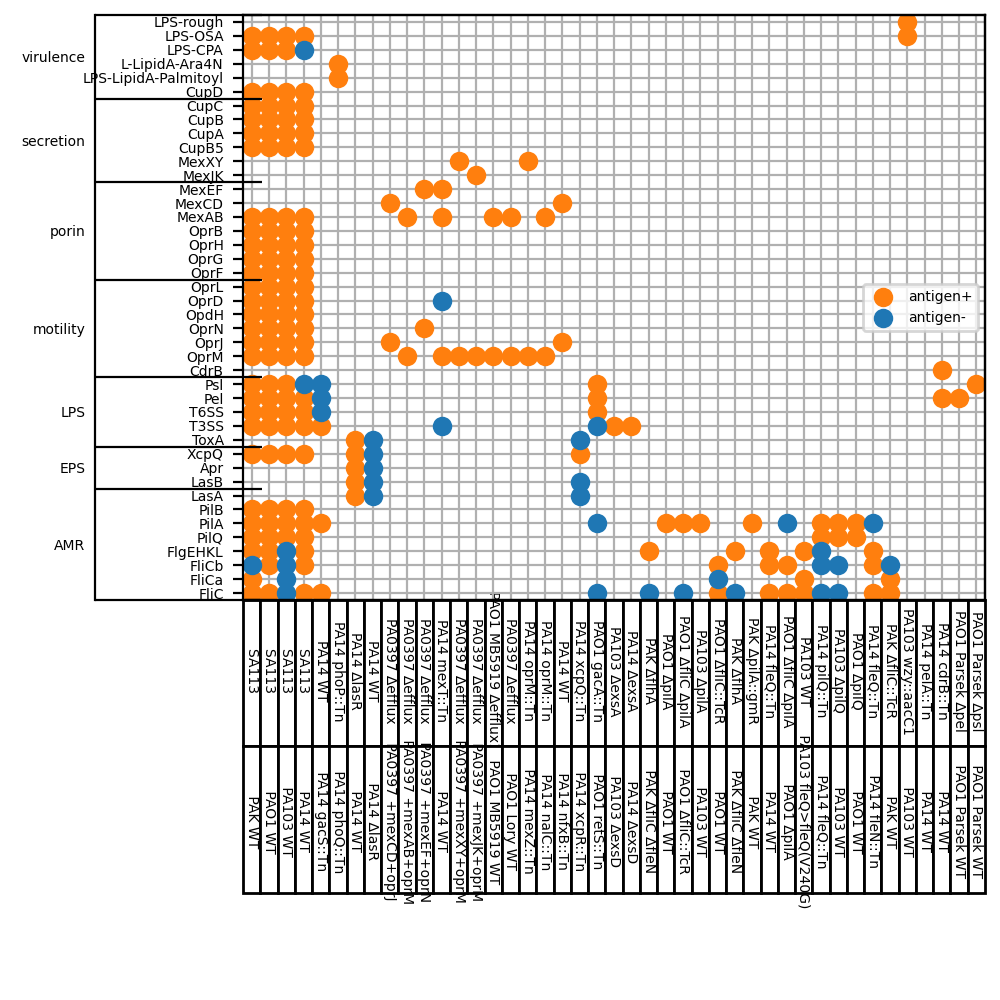

In [44]:
pheno_grid_subset = pheno_grid.loc[subset_samples,:].dropna(axis='columns',how='all').drop(columns=['LPS','TonB'])
fig, ax = plot_ag_matrix([pheno_grid_subset], x_order=subset_samples, kws=[{}], figsize=(5,5), labels=['antigen'], table_height=0.5, ag_grouping_tick_length=60, ag_grouping_pos=-0.2)

fig.tight_layout()
plt.show()
fig.savefig("results/plots/antigens/matrix_subset.svg")